In [1]:
%load_ext autoreload
%autoreload 2

import crud as crud
import pandas as pd
import matplotlib

In [2]:
triplets = pd.read_csv('../data/train_triplets.txt', sep="\t", header=None)
triplets.columns=['user_id', 'song_id', 'play_count']
triplets['user_id_idx'] = triplets.groupby('user_id').ngroup()
triplets['song_id_idx'] = triplets.groupby('song_id').ngroup()

In [3]:
triplets.head()

,user_id,song_id,play_count,user_id_idx,song_id_idx
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,732659,6347
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,732659,9365
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,732659,16962
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,732659,19513
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,732659,19536


In [51]:
triplets.loc[triplets.play_count>=5].shape

(7261443, 5)

count    1.019318e+06
mean     4.745682e+01
std      5.781573e+01
min      1.000000e+01
25%      1.600000e+01
50%      2.700000e+01
75%      5.500000e+01
max      4.400000e+03
Name: song_id, dtype: float64


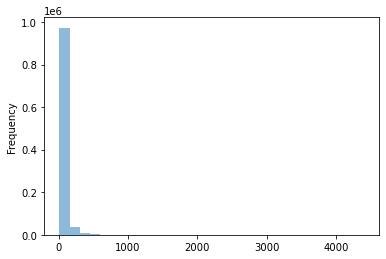

In [4]:
triplets_summary = triplets.groupby('user_id')['song_id'].count()
print(triplets_summary.describe())
ax = triplets_summary.plot.hist(bins=30, alpha=0.5)

In [5]:
import random
import math
random.seed(1234)

user_ids = triplets.user_id.unique()
random.shuffle(user_ids)
user_ids_train = user_ids[:math.floor(0.9 * len(user_ids))]
user_ids_test = user_ids[math.floor(0.9 * len(user_ids)):]


In [6]:
from pathlib import Path

output_dir = Path('../experiments/triplets')
output_dir.mkdir(parents=True, exist_ok=True)

triplets.loc[triplets.user_id.isin(user_ids_train)].to_csv(output_dir / "train.csv", index=False)
triplets.loc[triplets.user_id.isin(user_ids_test)].to_csv(output_dir / "test.csv", index=False)

In [7]:
conn = crud.create_connection("../db/track_metadata.db")
tables = crud.get_tables(conn)

for table_name in tables.name.tolist():
    print(table_name)
    records = crud.get_records(conn, table_name)
    print(records.head())

songs
             track_id              title             song_id  \
0  TRMMMYQ128F932D901       Silent Night  SOQMMHC12AB0180CB8   
1  TRMMMKD128F425225D        Tanssi vaan  SOVFVAK12A8C1350D9   
2  TRMMMRX128F93187D9  No One Could Ever  SOGTUKN12AB017F4F1   
3  TRMMMCH128F425532C      Si Vos Querés  SOBNYVR12A8C13558C   
4  TRMMMWA128F426B589   Tangle Of Aspens  SOHSBXH12A8C13B0DF   

                                release           artist_id  \
0                 Monster Ballads X-Mas  ARYZTJS1187B98C555   
1                           Karkuteillä  ARMVN3U1187FB3A1EB   
2                                Butter  ARGEKB01187FB50750   
3                               De Culo  ARNWYLR1187B9B2F9C   
4  Rene Ablaze Presents Winter Sessions  AREQDTE1269FB37231   

                            artist_mbid       artist_name   duration  \
0  357ff05d-848a-44cf-b608-cb34b5701ae5  Faster Pussy cat  252.05506   
1  8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9  Karkkiautomaatti  156.55138   
2  3d403d44-36

In [8]:
tracks = records[['track_id', 'title', 'song_id']]
tracks.to_csv('./tracks.csv', index=False)
tracks.head()

,track_id,title,song_id
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C
4,TRMMMWA128F426B589,Tangle Of Aspens,SOHSBXH12A8C13B0DF


In [9]:
records_columns = ['song_id', 'artist_id', 'duration', 'artist_familiarity', 'artist_hotttnesss']
songs = records[records_columns].groupby(['song_id', 'artist_id']).mean().reset_index()
songs.head()

,song_id,artist_id,duration,artist_familiarity,artist_hotttnesss
0,SOAAABI12A8C13615F,ARJQVBE1187FB3D623,264.04526,0.575041,0.368380
1,SOAAABT12AC46860F0,ARAXBHJ1269FCCED10,352.46975,0.027504,0.000000
2,SOAAABX12A8C13FEB2,AR8I0Z71187FB43D5A,316.08118,0.494969,0.386387
3,SOAAACR12A58A79456,ARPLE851187B9B2B7C,210.46812,0.547228,0.364787
4,SOAAACY12A58A79663,AR6IV601187B99B0BB,51.22567,0.439661,0.378042


In [10]:
n_users = triplets.user_id.nunique()
n_songs = triplets.song_id.nunique()

In [11]:
from pathlib import Path

def to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness):
  # order of features: user, movie, tags
    user_start_idx = 0
    song_start_idx = n_users
    duration_start_idx = song_start_idx + n_songs
    familiarity_start_idx = duration_start_idx + 1
    hotness_start_idx = familiarity_start_idx + 1
    
    return "{} {}:1 {}:1 {}:{} {}:{} {}:{}\n".format(
        rating,
        uid,
        sid + song_start_idx, 
        duration_start_idx, duration,
        familiarity_start_idx, familiarity,
        hotness_start_idx, hotness
    )

output_dir = Path('../experiments/metadata')
output_dir.mkdir(parents=True, exist_ok=True)

meta_columns = ['play_count', 'user_id_idx', 'song_id_idx', 'duration', 'artist_familiarity', 'artist_hotttnesss']

train_df = triplets.loc[triplets.user_id.isin(user_ids_train)].merge(songs.drop(columns=['artist_id']), on='song_id')
print(train_df.head())
test_df = triplets.loc[triplets.user_id.isin(user_ids_test)].merge(songs.drop(columns=['artist_id']), on='song_id')
print(test_df.head())

# save training data to file
with open(output_dir / "train.libfm", "w") as f:
    for rating, uid, sid, duration, familiarity, hotness, *_ in train_df[meta_columns].itertuples(index=False):
        f.write(to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness))

# save test data to file
with open(output_dir / "test.libfm", "w") as f:
    for rating, uid, sid, duration, familiarity, hotness, *_ in test_df[meta_columns].itertuples(index=False):
        f.write(to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness))

                                    user_id             song_id  play_count  \
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995           1   
1  7c86176941718984fed11b7c0674ff04c029b480  SOAKIMP12A8C130995           1   
2  76235885b32c4e8c82760c340dc54f9b608d7d7e  SOAKIMP12A8C130995           3   
3  250c0fa2a77bc6695046e7c47882ecd85c42d748  SOAKIMP12A8C130995           1   
4  3f73f44560e822344b0fb7c6b463869743eb9860  SOAKIMP12A8C130995           6   

   user_id_idx  song_id_idx   duration  artist_familiarity  artist_hotttnesss  
0       732659         6347  112.63955            0.832012           0.677482  
1       495616         6347  112.63955            0.832012           0.677482  
2       470229         6347  112.63955            0.832012           0.677482  
3       146870         6347  112.63955            0.832012           0.677482  
4       252033         6347  112.63955            0.832012           0.677482  
                                    user_id  

In [ ]:
def to_fm_sparse_fmt(rating, uid, mid, tags):
  # order of features: user, movie, tags
    user_start_idx = 0
    song_start_idx = n_users
    duration_start_idx = song_start_idx + n_songs
    familiarity_start_idx = duration_start_idx + 1
    hotness_start_idx = familiarity_start_idx + 1
    
    return "{} {}:1 {}:1 {}\n".format(
        rating,
        uid,
        sid + song_start_idx,
        duration_start_idx, duration,
        familiarity_start_idx, familiarity,
        hotness_start_idx, hotness,
        " ".join("{}:1".format(tag_id2idx[t] + tag_start_idx) for t in tags)
    )

In [12]:
conn = crud.create_connection("../db/artist_term.db")
tables = crud.get_tables(conn)

for table_name in tables.name.tolist():
    print(table_name)
    records = crud.get_records(conn, table_name)
    print(records.head())
    if table_name == "artist_term":
        break

artists
            artist_id
0  AR002UA1187B9A637D
1  AR003FB1187B994355
2  AR006821187FB5192B
3  AR009211187B989185
4  AR009SZ1187B9A73F4
terms
              term
0              00s
1  00s alternative
2      00s country
3        00s indie
4          00s pop
artist_term
            artist_id          term
0  AR002UA1187B9A637D   garage rock
1  AR002UA1187B9A637D  country rock
2  AR002UA1187B9A637D     free jazz
3  AR002UA1187B9A637D            oi
4  AR002UA1187B9A637D    space rock


In [13]:
artist_term = records
artist_term['term_id'] = artist_term.groupby('term').ngroup()
n_terms = artist_term.term_id.max()
artist_term_lookup = artist_term[['artist_id', 'term_id']].drop_duplicates()
artist_term_lookup.to_csv("./artist_term_lookup.csv", index=False)
artist_term = artist_term[['artist_id', 'term_id']].groupby('artist_id').agg(list).reset_index()
artist_term.to_csv("./artist_term.csv", index=False)
artist_term.head()

,artist_id,term_id
0,AR002UA1187B9A637D,"[2931, 1611, 2746, 5118, 6607, 5557, 3600, 589..."
1,AR003FB1187B994355,"[6002, 5748, 293, 3408, 7021, 7329, 3290, 1724..."
2,AR006821187FB5192B,"[5192, 5182, 5927, 5936, 1090, 4265, 603, 2102..."
3,AR009211187B989185,"[4256, 5898, 6103, 7275, 564, 1749, 1930, 6659..."
4,AR009SZ1187B9A73F4,"[1259, 2880, 4828, 1998, 2712, 7181, 5066, 185..."


In [14]:
from pathlib import Path

def to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, terms):
  # order of features: user, movie, tags
    user_start_idx = 0
    song_start_idx = n_users
    duration_start_idx = song_start_idx + n_songs
    familiarity_start_idx = duration_start_idx + 1
    hotness_start_idx = familiarity_start_idx + 1
    artist_term_start_idx = hotness_start_idx + 1
    
    return "{} {}:1 {}:1 {}:{} {}:{} {}:{} {}\n".format(
        rating,
        uid,
        sid + song_start_idx,
        duration_start_idx, duration,
        familiarity_start_idx, familiarity,
        hotness_start_idx, hotness,
        " ".join("{}:1".format(t + artist_term_start_idx) for t in terms)
    )

output_dir = Path('../experiments/metadata_artist')
output_dir.mkdir(parents=True, exist_ok=True)

meta_columns = ['play_count', 'user_id_idx', 'song_id_idx', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'term_id']

train_df = triplets.loc[triplets.user_id.isin(user_ids_train)].merge(songs, on='song_id').merge(artist_term, on="artist_id").drop(columns=['artist_id'])
print(train_df.head())
test_df = triplets.loc[triplets.user_id.isin(user_ids_test)].merge(songs, on='song_id').merge(artist_term, on="artist_id").drop(columns=['artist_id'])
print(test_df.head())

# save training data to file
with open(output_dir / "train.libfm", "w") as f:
    for rating, uid, sid, duration, familiarity, hotness, terms, *_ in train_df[meta_columns].itertuples(index=False):
        f.write(to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, terms))

# save test data to file
with open(output_dir / "test.libfm", "w") as f:
    for rating, uid, sid, duration, familiarity, hotness, terms, *_ in test_df[meta_columns].itertuples(index=False):
        f.write(to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, terms))

                                    user_id             song_id  play_count  \
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995           1   
1  7c86176941718984fed11b7c0674ff04c029b480  SOAKIMP12A8C130995           1   
2  76235885b32c4e8c82760c340dc54f9b608d7d7e  SOAKIMP12A8C130995           3   
3  250c0fa2a77bc6695046e7c47882ecd85c42d748  SOAKIMP12A8C130995           1   
4  3f73f44560e822344b0fb7c6b463869743eb9860  SOAKIMP12A8C130995           6   

   user_id_idx  song_id_idx   duration  artist_familiarity  artist_hotttnesss  \
0       732659         6347  112.63955            0.832012           0.677482   
1       495616         6347  112.63955            0.832012           0.677482   
2       470229         6347  112.63955            0.832012           0.677482   
3       146870         6347  112.63955            0.832012           0.677482   
4       252033         6347  112.63955            0.832012           0.677482   

                                      

In [15]:
conn = crud.create_connection("../db/mxm_dataset.db")
tables = crud.get_tables(conn)

for table_name in tables.name.tolist():
    print(table_name)
    records = crud.get_records(conn, table_name)
    print(records.head())

words
  word
0    i
1  the
2  you
3   to
4  and
lyrics
             track_id  mxm_tid word  count  is_test
0  TRAAAAV128F421A322  4623710    i      6        0
1  TRAAAAV128F421A322  4623710  the      4        0
2  TRAAAAV128F421A322  4623710  you      2        0
3  TRAAAAV128F421A322  4623710   to      2        0
4  TRAAAAV128F421A322  4623710  and      5        0


In [36]:
lyrics = records 
lyrics['word_id'] = lyrics.groupby('word').ngroup()
n_lyrics = lyrics.word_id.max()
lyrics_word_lookup = lyrics[['word_id', 'word']].drop_duplicates()
lyrics_word_lookup.to_csv("./lyrics_word_lookup.csv", index=False)
lyrics = lyrics.merge(tracks[['track_id', 'song_id']], on='track_id')[['song_id', 'word_id', 'count']].drop_duplicates()
lyrics = lyrics.groupby('song_id')[['word_id', 'count']].apply(lambda g: g.values.tolist()).reset_index()
lyrics.columns = ['song_id', 'lyrics']
lyrics.to_csv("./lyrics.csv", index=False)
lyrics.head()

,song_id,lyrics
0,SOAAADP12A8C1413C7,"[[2107, 7], [4347, 11], [4958, 3], [4413, 2], ..."
1,SOAAAFI12A6D4F9C66,"[[2107, 10], [4347, 5], [4958, 3], [4413, 5], ..."
2,SOAAAGK12AB0189572,"[[2107, 15], [4347, 8], [4958, 2], [4413, 11],..."
3,SOAAAGP12A6D4F7D1C,"[[2107, 1], [4347, 16], [4958, 7], [4413, 7], ..."
4,SOAAAKE12A67AD7460,"[[25, 1], [2636, 1], [3036, 3], [3419, 1], [10..."


In [17]:
from pathlib import Path

def to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, lyric):
  # order of features: user, movie, tags
    user_start_idx = 0
    song_start_idx = n_users
    duration_start_idx = song_start_idx + n_songs
    familiarity_start_idx = duration_start_idx + 1
    hotness_start_idx = familiarity_start_idx + 1
    lyric_start_idx = hotness_start_idx + 1
    
    return "{} {}:1 {}:1 {}:{} {}:{} {}:{} {}\n".format(
        rating,
        uid,
        sid + song_start_idx,
        duration_start_idx, duration,
        familiarity_start_idx, familiarity,
        hotness_start_idx, hotness,
        " ".join("{}:{}".format(t[0] + lyric_start_idx, t[1]) for t in lyric)
    )

output_dir = Path('../experiments/metadata_lyrics')
output_dir.mkdir(parents=True, exist_ok=True)

meta_columns = ['play_count', 'user_id_idx', 'song_id_idx', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'lyrics']

train_df = triplets.loc[triplets.user_id.isin(user_ids_train)].merge(songs, on='song_id').merge(lyrics, on="song_id").drop(columns=['artist_id'])
print(train_df.head())
test_df = triplets.loc[triplets.user_id.isin(user_ids_test)].merge(songs, on='song_id').merge(lyrics, on="song_id").drop(columns=['artist_id'])
print(test_df.head())

# save training data to file
with open(output_dir / "train.libfm", "w") as f:
    for rating, uid, sid, duration, familiarity, hotness, lyric, *_ in train_df[meta_columns].itertuples(index=False):
        f.write(to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, lyric))

# save test data to file
with open(output_dir / "test.libfm", "w") as f:
    for rating, uid, sid, duration, familiarity, hotness, lyric, *_ in test_df[meta_columns].itertuples(index=False):
        f.write(to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, lyric))

                                    user_id             song_id  play_count  \
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAPDEY12A81C210A9           1   
1  fd13b9d49c54e00ff413fe3c095ba581c7fc611e  SOAPDEY12A81C210A9           8   
2  35752a9e4d917c8fc5da88e90c25adc6b52220b6  SOAPDEY12A81C210A9           1   
3  bfe8d6d1e32d9de12c632d68712e7e4a23416e93  SOAPDEY12A81C210A9           1   
4  46d3ef1b4f317aba8f0226e937c67ecef9fa2e42  SOAPDEY12A81C210A9           4   

   user_id_idx  song_id_idx   duration  artist_familiarity  artist_hotttnesss  \
0       732659         9365  153.59955            0.580555           0.482492   
1      1007697         9365  153.59955            0.580555           0.482492   
2       212259         9365  153.59955            0.580555           0.482492   
3       763801         9365  153.59955            0.580555           0.482492   
4       281401         9365  153.59955            0.580555           0.482492   

                                      

In [19]:
from pathlib import Path

def to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, terms, lyric):
  # order of features: user, movie, tags
    user_start_idx = 0
    song_start_idx = n_users
    duration_start_idx = song_start_idx + n_songs
    familiarity_start_idx = duration_start_idx + 1
    hotness_start_idx = familiarity_start_idx + 1
    artist_term_start_idx = hotness_start_idx + 1
    lyric_start_idx = artist_term_start_idx + n_terms
    
    return "{} {}:1 {}:1 {}:{} {}:{} {}:{} {} {}\n".format(
        rating,
        uid,
        sid + song_start_idx,
        duration_start_idx, duration,
        familiarity_start_idx, familiarity,
        hotness_start_idx, hotness,
        " ".join("{}:1".format(t + artist_term_start_idx) for t in terms),
        " ".join("{}:{}".format(t[0] + lyric_start_idx, t[1]) for t in lyric)
    )

output_dir = Path('../experiments/metadata_artist_lyrics')
output_dir.mkdir(parents=True, exist_ok=True)

meta_columns = ['play_count', 'user_id_idx', 'song_id_idx', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'term_id', 'lyrics']

train_df = triplets.loc[triplets.user_id.isin(user_ids_train)].merge(songs, on='song_id').merge(lyrics, on="song_id").merge(artist_term, on="artist_id").drop(columns=['artist_id'])
print(train_df.head())
test_df = triplets.loc[triplets.user_id.isin(user_ids_test)].merge(songs, on='song_id').merge(lyrics, on="song_id").merge(artist_term, on="artist_id").drop(columns=['artist_id'])
print(test_df.head())

# save training data to file
with open(output_dir / "train.libfm", "w") as f:
    for rating, uid, sid, duration, familiarity, hotness, terms, lyric, *_ in train_df[meta_columns].itertuples(index=False):
        f.write(to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, terms, lyric))

# save test data to file
with open(output_dir / "test.libfm", "w") as f:
    for rating, uid, sid, duration, familiarity, hotness, terms, lyric, *_ in test_df[meta_columns].itertuples(index=False):
        f.write(to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, terms, lyric))

                                    user_id             song_id  play_count  \
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAPDEY12A81C210A9           1   
1  fd13b9d49c54e00ff413fe3c095ba581c7fc611e  SOAPDEY12A81C210A9           8   
2  35752a9e4d917c8fc5da88e90c25adc6b52220b6  SOAPDEY12A81C210A9           1   
3  bfe8d6d1e32d9de12c632d68712e7e4a23416e93  SOAPDEY12A81C210A9           1   
4  46d3ef1b4f317aba8f0226e937c67ecef9fa2e42  SOAPDEY12A81C210A9           4   

   user_id_idx  song_id_idx   duration  artist_familiarity  artist_hotttnesss  \
0       732659         9365  153.59955            0.580555           0.482492   
1      1007697         9365  153.59955            0.580555           0.482492   
2       212259         9365  153.59955            0.580555           0.482492   
3       763801         9365  153.59955            0.580555           0.482492   
4       281401         9365  153.59955            0.580555           0.482492   

                                      

In [20]:
spotify_id = pd.read_csv('./spotify_ids.csv', header=None, sep='|', error_bad_lines=False, warn_bad_lines=False, names=
                  ['query', 'spotify_title', 'spotify_artist', 'spotify_album', 'spotify_release', 'spotify_uri', 'track_id']
                  )
spotify_id = spotify_id.loc[~spotify_id.spotify_uri.isna()]
spotify_id = spotify_id.merge(tracks[['track_id', 'song_id']], on='track_id')[['spotify_uri', 'song_id', 'spotify_release']].drop_duplicates()
spotify_id.head()

,spotify_uri,song_id,spotify_release
0,spotify:track:3ZqUZpeWJ4norA5nvrE98c,SOQMMHC12AB0180CB8,2007-09-11
1,spotify:track:5PS5dpaLogPzYU9hWiWyZb,SOVFVAK12A8C1350D9,2006
2,spotify:track:41RpZW2lxAdnqDd2nMBzLQ,SOGTUKN12AB017F4F1,2009-10-12
3,spotify:track:2poHURuOfVNbzZdivAwtOH,SOHSBXH12A8C13B0DF,2008-01-01
4,spotify:track:0vI1QELUdb0RM94mnrd8mO,SOZVAPQ12A8C13B63C,1996-08-30


In [21]:
audio_features = pd.read_csv("./spotify_audio_features.csv")
audio_features = audio_features.add_prefix('spotify_')
print(audio_features.shape)
audio_features = audio_features.loc[audio_features.spotify_energy!=-1]
print(audio_features.shape)
audio_features.head()

(790704, 13)
(790599, 13)


,spotify_uri,spotify_danceability,spotify_energy,spotify_key,spotify_loudness,spotify_mode,spotify_speechiness,spotify_acousticness,spotify_instrumentalness,spotify_liveness,spotify_valence,spotify_tempo,spotify_time_signature
0,spotify:track:3ZqUZpeWJ4norA5nvrE98c,0.453,0.915,0,-4.893,1,0.0354,0.000005,0.6310,0.1190,0.660,174.040,4
1,spotify:track:5PS5dpaLogPzYU9hWiWyZb,0.487,0.678,9,-7.780,1,0.0495,0.001300,0.0551,0.0846,0.870,149.940,4
2,spotify:track:41RpZW2lxAdnqDd2nMBzLQ,0.662,0.823,4,-1.711,0,0.0662,0.000045,0.9520,0.3430,0.621,177.745,4
3,spotify:track:2poHURuOfVNbzZdivAwtOH,0.430,0.960,5,-7.741,0,0.0431,0.000725,0.9250,0.1230,0.225,140.001,4
4,spotify:track:0vI1QELUdb0RM94mnrd8mO,0.202,0.095,10,-21.228,1,0.0347,0.961000,0.7710,0.1360,0.114,89.211,4


In [39]:
spotify = spotify_id.merge(audio_features, on="spotify_uri").drop(columns=['spotify_uri', 'spotify_release']).drop_duplicates()
spotify = spotify.groupby('song_id').mean().reset_index()
print(spotify.song_id.nunique())
print(spotify.shape)
spotify_cols = [col for col in spotify.columns if col != 'song_id']
spotify = pd.melt(spotify, id_vars=['song_id'], value_vars=spotify_cols)
spotify = spotify.groupby('song_id')[['variable', 'value']].apply(lambda g: g.values.tolist()).reset_index()
spotify.columns = ['song_id', 'spotify']
spotify.head()

789804
(789804, 13)


,song_id,spotify
0,SOAAABT12AC46860F0,"[[spotify_danceability, 0.29100000000000004], ..."
1,SOAAABX12A8C13FEB2,"[[spotify_danceability, 0.8240000000000001], [..."
2,SOAAACR12A58A79456,"[[spotify_danceability, 0.705], [spotify_energ..."
3,SOAAACY12A58A79663,"[[spotify_danceability, 0.18899999999999997], ..."
4,SOAAADD12AB018A9DD,"[[spotify_danceability, 0.225], [spotify_energ..."


In [49]:
from pathlib import Path

def to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, terms, lyric, spotify_audio):
  # order of features: user, movie, tags
    user_start_idx = 0
    song_start_idx = n_users
    duration_start_idx = song_start_idx + n_songs
    familiarity_start_idx = duration_start_idx + 1
    hotness_start_idx = familiarity_start_idx + 1
    artist_term_start_idx = hotness_start_idx + 1
    lyric_start_idx = artist_term_start_idx + n_terms
    audio_start_idx = lyric_start_idx + n_lyrics
    
    return "{} {}:1 {}:1 {}:{} {}:{} {}:{} {} {} {} \n".format(
        rating,
        uid,
        sid + song_start_idx,
        duration_start_idx, duration,
        familiarity_start_idx, familiarity,
        hotness_start_idx, hotness,
        " ".join("{}:1".format(t + artist_term_start_idx) for t in terms),
        " ".join("{}:{}".format(l[0] + lyric_start_idx, l[1]) for l in lyric),
        " ".join("{}:{}".format(spotify_cols.index(s[0]) + audio_start_idx, s[1]) for s in spotify_audio)
    )

output_dir = Path('../experiments/metadata_artist_lyrics_spotify')
output_dir.mkdir(parents=True, exist_ok=True)

meta_columns = ['play_count', 'user_id_idx', 'song_id_idx', 
                'duration', 'artist_familiarity', 'artist_hotttnesss', 
                'term_id', 'lyrics', 'spotify']

train_df = (
    triplets
    .loc[triplets.user_id.isin(user_ids_train)]
    .merge(songs, on='song_id')
    .merge(lyrics, on="song_id")
    .merge(artist_term, on="artist_id")
    .merge(spotify, on="song_id")
    .drop(columns=['artist_id'])
)
print(train_df.head())
test_df = (
    triplets
    .loc[triplets.user_id.isin(user_ids_test)]
    .merge(songs, on='song_id')
    .merge(lyrics, on="song_id")
    .merge(artist_term, on="artist_id")
    .merge(spotify, on="song_id")
    .drop(columns=['artist_id'])
)
print(test_df.head())

# save training data to file
with open(output_dir / "train.libfm", "w") as f:
    for rating, uid, sid, duration, familiarity, hotness, terms, lyric, spotify_audio, *_ in train_df[meta_columns].itertuples(index=False):
        f.write(to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, terms, lyric, spotify_audio))

# save test data to file
with open(output_dir / "test.libfm", "w") as f:
    for rating, uid, sid, duration, familiarity, hotness, terms, lyric, spotify_audio, *_ in test_df[meta_columns].itertuples(index=False):
        f.write(to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, terms, lyric, spotify_audio))

                                    user_id             song_id  play_count  \
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAPDEY12A81C210A9           1   
1  fd13b9d49c54e00ff413fe3c095ba581c7fc611e  SOAPDEY12A81C210A9           8   
2  35752a9e4d917c8fc5da88e90c25adc6b52220b6  SOAPDEY12A81C210A9           1   
3  bfe8d6d1e32d9de12c632d68712e7e4a23416e93  SOAPDEY12A81C210A9           1   
4  46d3ef1b4f317aba8f0226e937c67ecef9fa2e42  SOAPDEY12A81C210A9           4   

   user_id_idx  song_id_idx   duration  artist_familiarity  artist_hotttnesss  \
0       732659         9365  153.59955            0.580555           0.482492   
1      1007697         9365  153.59955            0.580555           0.482492   
2       212259         9365  153.59955            0.580555           0.482492   
3       763801         9365  153.59955            0.580555           0.482492   
4       281401         9365  153.59955            0.580555           0.482492   

                                      

In [61]:
from pathlib import Path

def to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, spotify_audio):
  # order of features: user, movie, tags
    user_start_idx = 0
    song_start_idx = n_users
    duration_start_idx = song_start_idx + n_songs
    familiarity_start_idx = duration_start_idx + 1
    hotness_start_idx = familiarity_start_idx + 1
    audio_start_idx = hotness_start_idx + n_lyrics
    
    return "{} {}:1 {}:1 {}:{} {}:{} {}:{} {}\n".format(
        rating,
        uid,
        sid + song_start_idx,
        duration_start_idx, duration,
        familiarity_start_idx, familiarity,
        hotness_start_idx, hotness,
        " ".join("{}:{}".format(spotify_cols.index(s[0]) + audio_start_idx, s[1]) for s in spotify_audio)
    )

output_dir = Path('../experiments/metadata_spotify')
output_dir.mkdir(parents=True, exist_ok=True)

meta_columns = ['play_count', 'user_id_idx', 'song_id_idx', 
                'duration', 'artist_familiarity', 'artist_hotttnesss', 
                'spotify']

train_df = (
    triplets
    .loc[triplets.user_id.isin(user_ids_train)]
    .merge(songs, on='song_id')
    .merge(spotify, on="song_id")
    .drop(columns=['artist_id'])
)
print(train_df.head())
test_df = (
    triplets
    .loc[triplets.user_id.isin(user_ids_test)]
    .merge(songs, on='song_id')
    .merge(spotify, on="song_id")
    .drop(columns=['artist_id'])
)
print(test_df.head())

# save training data to file
with open(output_dir / "train.libfm", "w") as f:
    for rating, uid, sid, duration, familiarity, hotness, spotify_audio, *_ in train_df[meta_columns].itertuples(index=False):
        f.write(to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, spotify_audio))

# save test data to file
with open(output_dir / "test.libfm", "w") as f:
    for rating, uid, sid, duration, familiarity, hotness, spotify_audio, *_ in test_df[meta_columns].itertuples(index=False):
        f.write(to_fm_sparse_fmt(rating, uid, sid, duration, familiarity, hotness, spotify_audio))

                                    user_id             song_id  play_count  \
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995           1   
1  7c86176941718984fed11b7c0674ff04c029b480  SOAKIMP12A8C130995           1   
2  76235885b32c4e8c82760c340dc54f9b608d7d7e  SOAKIMP12A8C130995           3   
3  250c0fa2a77bc6695046e7c47882ecd85c42d748  SOAKIMP12A8C130995           1   
4  3f73f44560e822344b0fb7c6b463869743eb9860  SOAKIMP12A8C130995           6   

   user_id_idx  song_id_idx   duration  artist_familiarity  artist_hotttnesss  \
0       732659         6347  112.63955            0.832012           0.677482   
1       495616         6347  112.63955            0.832012           0.677482   
2       470229         6347  112.63955            0.832012           0.677482   
3       146870         6347  112.63955            0.832012           0.677482   
4       252033         6347  112.63955            0.832012           0.677482   

                                      